In [1]:
from libs.Dataset import *
from libs.SiameseNetwork import *
import matplotlib.pyplot as plt
import dill # allow to save notebook session, useful for test https://towardsdatascience.com/how-to-restore-your-jupyter-notebook-session-dfeadbd86d65
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback, progress
from torch.optim import SGD
from torch import nn
import torch

In [2]:
# load datamodule sessions
dill.load_session('notebook_env.db')

### Test Single Trashbin Pytorch Lighting DataModule

In [5]:
# Init our data pipeline
dm = TrashbinDataModule(data_dir= "dataset/")
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

Do nothing...


/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


In [3]:
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
print("Required shape: val_imgs: {} val_shapes: {}".format(val_imgs.shape, val_labels.shape))

Required shape: val_imgs: torch.Size([32, 3, 28, 28]) val_shapes: torch.Size([32])


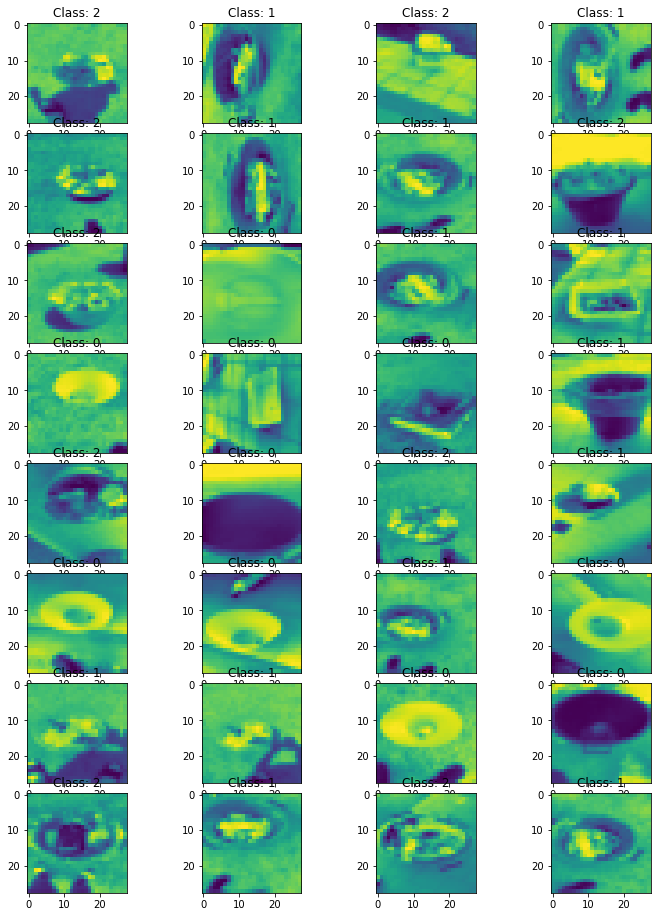

In [4]:
images, labels = iter(dm.train_dataloader()).next()
plt.figure(figsize = (12,16))
for e,(img, lbl) in enumerate(zip(images, labels)):
    plt.subplot(8,4,e+1)
    plt.imshow(img[0])
    plt.title(f'Class: {lbl.item()}')

plt.subplots_adjust(hspace=0.1)

### Test Triplet Trashbin Pytorch Lighting Data Module

In [2]:
# Init our data pipeline
dm = TripletTrashbinDataModule(data_dir= "dataset/")
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

Do nothing on prepare_data


/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


In [4]:
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
print("Required shape: val_imgs: {} val_shapes: {}".format(val_imgs.shape, val_labels.shape))

Required shape: val_imgs: torch.Size([32, 3, 28, 28]) val_shapes: torch.Size([32, 3, 28, 28])


Print Train Dataset with matplotlib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

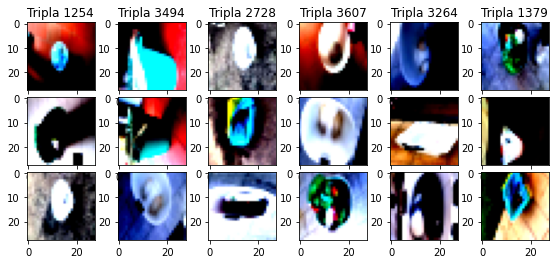

In [4]:
plt.figure(figsize=(16,4))
for i, idx in enumerate(np.random.choice(len(dm.trb_train), 6)):
    ax = plt.subplot(3,10,i+1)
    ax.set_title('Tripla {}'.format(idx))
    
    plt.imshow(dm.trb_train[i][0].T)
    plt.subplot(3,10,i+11)
    # plt.title('Class: {}'.format(dm.trb_train[i][3]))
    plt.imshow(dm.trb_train[i][1].T)
    # plt.title('Class: {}'.format(dm.trb_train[i][4]))
    plt.subplot(3,10,i+21)
    plt.imshow(dm.trb_train[i][2].T)
    # plt.title('Class: {}'.format(dm.trb_train[i][5]))

plt.subplots_adjust(hspace=0.1)
plt.show()

In [3]:
dill.dump_session('notebook_env.db')

### Test EmbeddingNet and TripletNetworkTask (saving and loading .ckpt)

In [6]:
model = EmbeddingNet()
print("Model want {}".format(model(torch.zeros(32,3,28,28)).shape))

Model want torch.Size([32, 128])


In [7]:
triplet_tb_task = TripletNetworkTask(EmbeddingNet())
logger = TensorBoardLogger("metric_logs", name="siamese_trashbin")
trainer = pl.Trainer(gpus=0,
                    max_epochs=1,
                    callbacks=[progress.TQDMProgressBar()],
                    logger=logger,
                    accelerator="auto")
# TODO: Test
trainer.fit(model=triplet_tb_task,
            datamodule=dm )
            # train_dataloaders=dm.train_dataloader(),
            # test_dataloaders=dm.test_dataloader(),
            # val_dataloaders=dm.val_dataloader() )

/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name          | Type              | Params
---------------------------

loss embedd 113.84937286376953
loss 1.7178640365600586
loss embedd 112.726806640625
loss 1.9785915613174438
loss embedd 114.87791442871094
loss 2.1346750259399414
loss embedd 113.87545776367188
loss 2.3685147762298584
loss embedd 115.5842056274414
loss 2.1355581283569336
loss embedd 116.44608306884766
loss 1.9259997606277466
loss embedd 114.62315368652344
loss 1.882974624633789
loss embedd 115.83134460449219
loss 1.6074159145355225
loss embedd 118.53451538085938
loss 1.7180728912353516
loss embedd 120.10432434082031
loss 2.106144905090332
loss embedd 123.62129211425781
loss 1.5300546884536743
loss embedd 121.8681640625
loss 1.6882331371307373
loss embedd 124.89738464355469
loss 1.5720995664596558
loss embedd 125.22666931152344
loss 1.859055757522583
loss embedd 125.18194580078125
loss 1.6669729948043823
loss embedd 129.3650665283203
loss 2.121579647064209
loss embedd 124.28556060791016
loss 2.1310665607452393
loss embedd 132.90728759765625
loss 2.5210580825805664
loss embedd 130.755584

Continue training of model loaded from checkpoint

In [9]:
loaded_trainer = pl.Trainer(gpus=0, logger=logger, max_epochs=2, progress_bar_refresh_rate=0, accelerator="auto")

loaded_trainer.fit(model=triplet_tb_task, datamodule=dm, ckpt_path='metric_logs/siamese_trashbin/version_0/checkpoints/epoch=0-step=206.ckpt')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint path at metric_logs/siamese_trashbin/version_0/checkpoints/epoch=0-step=206.ckpt
/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:250: UserWarning: You're resuming from a checkpoint that ended mid-epoch. Training will start from the beginning of the next epoch. This can cause unreliable results if further training is done, consider using an end of epoch checkpoint.
  rank_zero_warn(
Restored all states from the checkpoint file at metric_logs/siamese_trashbin/version_0/checkpoints/epoch=0-step=206.ckpt

  | Name          | Type              | Params
----------------------------------------------------
0 | embedding_net | EmbeddingNet      | 351 K 
1 | criterion     | TripletMarginLoss | 0     
----------------------------------------------------
351 K     Trainab

loss embedd 146.3374786376953
loss 1.502960443496704
loss embedd 147.58480834960938
loss 1.127360463142395
loss embedd 149.36972045898438
loss 0.7659599184989929
loss embedd 149.03939819335938
loss 1.1414271593093872
loss embedd 145.11752319335938
loss 0.6633528470993042
loss embedd 143.89437866210938
loss 0.8967848420143127
loss embedd 139.11221313476562
loss 0.9598866105079651
loss embedd 140.7921600341797
loss 1.5635268688201904
loss embedd 141.66415405273438
loss 1.18777596950531
loss embedd 152.98207092285156
loss 1.4955188035964966
loss embedd 153.30978393554688
loss 0.5497342348098755
loss embedd 155.8250732421875
loss 1.202786922454834
loss embedd 154.37240600585938
loss 0.8141043186187744
loss embedd 152.4798126220703
loss 0.9719492793083191
loss embedd 156.97900390625
loss 0.9587354063987732
loss embedd 153.8760528564453
loss 1.0882503986358643
loss embedd 159.29298400878906
loss 0.6013455390930176
loss embedd 158.20529174804688
loss 2.097079038619995
loss embedd 160.77536010

### Test pretrained mobilenet_v2 used as feature extractor in SiameseTripletNetwork

In [3]:
print("Dims datamodel: {}".format(dm.dims))

Dims datamodel: (3, 28, 28)


/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


In [18]:
from torchvision.models import mobilenet_v2

# uso mobileNetV2 come primo esempio
mobilenet_fe = mobilenet_v2(pretrained=True)

# TODO: Riadatto l'input perché voglio testare al momento imamgini rgb 32x32
mobilenet_fe.features[0] = nn.Conv2d(3,32,5)

# rimuovo classificatore finale, imposto il modulo identità al posto del classificatore
mobilenet_fe.classifier = nn.Identity()

print("Dimensione del vettore di feature estratto per immagine {} -> {}".format(torch.zeros(1,3,32,32).shape, mobilenet_fe(torch.zeros(1,3,32,32)).shape))

Dimensione del vettore di feature estratto per immagine torch.Size([1, 3, 32, 32]) -> torch.Size([1, 1280])


In [ ]:
# TODO: Aggiungi test delle performance non ancora ottimizzate

In [21]:
triplet_mobilenetv2 = TripletNetworkTask(mobilenet_fe)
logger = TensorBoardLogger("metric_logs", name="siamese_mobilenetv2")
trainer = pl.Trainer(gpus=0,
                    max_epochs=1,
                    callbacks=[progress.TQDMProgressBar()],
                    logger=logger,
                    accelerator="auto")

trainer.fit(model=triplet_mobilenetv2, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name          | Type              | Params
----------------------------------------------------
0 | embedding_net | MobileNetV2       | 2.2 M 
1 | criterion     | TripletMarginLoss | 0     
----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.902     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/290 [00:00<?, ?it/s]                      loss embedd 90.23696899414062
loss 2.4159717559814453
Epoch 0:   0%|          | 1/290 [00:30<2:24:32, 30.01s/it, loss=2.42, v_num=0]loss embedd 108.33866882324219
loss 2.045464038848877
Epoch 0:   1%|          | 2/290 [00:31<1:15:42, 15.77s/it, loss=2.23, v_num=0]loss embedd 89.60981750488281
loss 1.8333431482315063
Epoch 0:   1%|          | 3/290 [00:33<52:43, 11.02s/it, loss=2.1, v_num=0]   loss embedd 92.94075012207031
loss 1.8134647607803345
Epoch 0:   1%|▏         | 4/290 [00:34<41:06,  8.62s/it, loss=2.03, v_num=0]loss embedd 82.41214752197266
loss 1.670674443244934
Epoch 0:   2%|▏         | 5/290 [00:35<33:45,  7.11s/it, loss=1.96, v_num=0]loss embedd 87.26182556152344
loss 3.3791072368621826
Epoch 0:   2%|▏         | 6/290 [00:36<29:08,  6.16s/it, loss=2.19, v_num=0]loss embedd 94.55865478515625
loss 1.5995850563049316


/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Test pretrained squeezeNet v2

In [3]:
from torchvision.models import squeezenet1_1

squezenet_fe = squeezenet1_1(pretrained=True)

# TODO: Riadatto l'input perché voglio testare al momento imamgini rgb 32x32

# rimuovo classificatore finale, imposto il modulo identità al posto del classificatore
squezenet_fe.classifier = nn.Identity()

print("Dimensione del vettore di feature estratto per immagine {} -> {}".format(torch.zeros(1,3,32,32).shape, squezenet_fe(torch.zeros(1,3,32,32)).shape))

Dimensione del vettore di feature estratto per immagine torch.Size([1, 3, 32, 32]) -> torch.Size([1, 512])


/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [4]:
triplet_squeezenet1_1 = TripletNetworkTask(squezenet_fe)
logger = TensorBoardLogger("metric_logs", name="siamese_squeezenet1_1")

In [5]:
trainer = pl.Trainer(gpus=0,
                    max_epochs=1,
                    callbacks=[progress.TQDMProgressBar()],
                    logger=logger,
                    accelerator="auto",
                    )

trainer.fit(model=triplet_squeezenet1_1, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name          | Type              | Params
----------------------------------------------------
0 | embedding_net | SqueezeNet        | 722 K 
1 | criterion     | TripletMarginLoss | 0     
----------------------------------------------------
722 K     Trainable params
0         Non-trainable params
722 K     Total params
2.890     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/290 [00:00<?, ?it/s]                      loss embedd 5122.333984375
loss 46.93275833129883
Epoch 0:   0%|          | 1/290 [00:28<2:19:11, 28.90s/it, loss=46.9, v_num=4]loss embedd 2446.50341796875
loss 14.848784446716309
Epoch 0:   1%|          | 2/290 [00:29<1:09:45, 14.53s/it, loss=30.9, v_num=4]loss embedd 2811.244140625
loss 15.768342971801758
Epoch 0:   1%|          | 3/290 [00:29<46:38,  9.75s/it, loss=25.8, v_num=4]  loss embedd 1442.3487548828125
loss 5.356313705444336
Epoch 0:   1%|▏         | 4/290 [00:29<35:04,  7.36s/it, loss=20.7, v_num=4]loss embedd 1010.3988037109375
loss 6.48053503036499
Epoch 0:   2%|▏         | 5/290 [00:29<28:11,  5.93s/it, loss=17.9, v_num=4]loss embedd 2228.843017578125
loss 7.878848075866699
Epoch 0:   2%|▏         | 6/290 [00:29<23:31,  4.97s/it, loss=16.2, v_num=4]loss embedd 2123.589111328125
loss 8.628548622131348
Epoch 0:   2%|▏         | 7/290 [00:30<20:13,  4.29s/it, loss=15.1, v_num=4]loss embedd 1196.66735839

/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [8]:
loaded_trainer = pl.Trainer(
    gpus=0,
    logger=logger,
    max_epochs=2,
    progress_bar_refresh_rate=0,
    accelerator="auto",
    resume_from_checkpoint=""
    )

loaded_trainer.fit(model=triplet_squeezenet1_1, datamodule=dm, ckpt_path='metric_logs/siamese_squeezenet1_1/version_1/checkpoints/epoch=0-step=206.ckpt')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint path at metric_logs/siamese_squeezenet1_1/version_1/checkpoints/epoch=0-step=206.ckpt
/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:250: UserWarning: You're resuming from a checkpoint that ended mid-epoch. Training will start from the beginning of the next epoch. This can cause unreliable results if further training is done, consider using an end of epoch checkpoint.
  rank_zero_warn(
Restored all states from the checkpoint file at metric_logs/siamese_squeezenet1_1/version_1/checkpoints/epoch=0-step=206.ckpt

  | Name          | Type              | Params
----------------------------------------------------
0 | embedding_net | SqueezeNet        | 722 K 
1 | criterion     | TripletMarginLoss | 0     
----------------------------------------------------
722 K  

loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2.0
loss_triplet 2